In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad,jit,vmap
#import tensorflow as tf
import matplotlib.pyplot as py
#tf.config.experimental.set_visible_devices([], "GPU")

### Data:

In [2]:
image1= np.ones((28,28)) *0.5

for i in range(2,22): 
  for j in range (2,22): 
    image1[i][j]=1

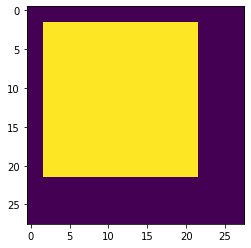

In [3]:
py.imshow(image1)

### Target

In [4]:
target= np.zeros((28,28))
for i in range(2,22): 
  for j in range (2,22): 
    target[i][j]=10

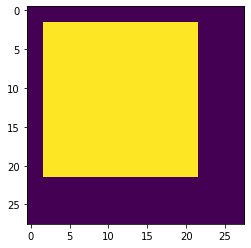

In [5]:
py.imshow(target)

### Reshape

In [6]:
#This needs to be changed to store x,y, I will store the third diemsnion later. 
#each mask contains an x,y coordinate which is what the affine transformation works on.
mask=np.zeros((784,2))
i = 0
for y in range(28):
    for x in range(28): 
      mask[i][0]=y#-14
      mask[i][1]=x#-14
      #mask[i][2]=1
      i+=1

affine_matrix = np.array([[1,0],
                [0,1]])


#The transformation is performed on this mask, and then the sampling occurs on the actual 'feature map'
#I believe this is what happens in Jaderberg et al.? 

In [7]:
modified_mask = np.dot (mask[2],affine_matrix.T)

In [8]:
feature=image1.reshape(784,2) 
target=target.reshape(784,2)
kernel = 10

ValueError: cannot reshape array of size 784 into shape (784,2)

### Network 
Sampling has to be something like

$ V^C_i = \sum^H_n\sum^W_m U^C_{nm} max (0,1-|x^s_i-m|)max(0,1-|y^s_i-n|)$

which has a very basic form of: 
$V = U \tau F(x,y) $ with $U$ being the feature map

$F(x,y)$ is the sampling, $U$ is the original feature map, and $\tau$ is the affine matrix

In [23]:
#feature_map will store the actual color value of the image
#mask will store the coordinates, which will be used for affine trasnformation. 
#affine_matrix is the actual transformation matrix. 
#The network decides if the pixel will have the affine trasnformation applied. 
def sampling_network(feature_map,parameters,bias):  #parameters will be 1,1  
    
    #The feature map then enters a sampling network, based on pixel value. 
    layer1=jnp.dot(feature_map,parameters[0].T) + bias[0]  #(32,1) 
    layer1=jax.nn.relu(layer1) 
    layer2=jnp.dot(layer1,parameters[1].T)+bias[1]  #(1,32)
    layer2=jax.nn.sigmoid(layer2) 
    return layer2
#This takes the sample output of the sampling_network (0 or 1) and 
#transform and outputs the final image in the form of (784,2)
def transformation_network (affine_matrix,coordinates,feature_map,parameters,bias): 
    #This is basically saying "perform the affine matrix, and apply it whether or not the sampling _networ
    #says to do it. "
    output= np.dot (cordinates,affine_matrix.T) * sampling_network(feature_map,parameters,bias)
    return output


vmap_forward= vmap(forward, in_axes =(0,None,None))

def MSE_error(pixels_,target,parameters,bias): 
  pred = forward(pixels_,parameters,bias) 
  error = 0.5*(target-pred)**2 #sum over image
  return error[0]

gradient=grad(MSE_error, argnums=(2,3))

def update_params(dparams,dbias,parameters,bias,lr=0.001): 
  for i in range(len(dparams)):
    parameters[i]=parameters[i] - (lr*dparams[i])
    bias[i] = bias[i] - (lr*dbias[i]) 
  return [parameters,bias]